# Классификация

# Рекомендация тарифов
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».   
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.    
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.   

## План дейставий  
1. Откройте файл с данными и изучите его. Путь к файлу: datasets/users_behavior.csv.
2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
4. Проверьте качество модели на тестовой выборке.
5. Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

[Этап 1. Исследование данных](#1)    
[Этап 2. Выбор модели](#2)     
[Этап 3. Проверка качества](#3)   
[Этап 4. sanity check](#4)   

## Библиотеки

In [1]:
import os
import pandas as pd
import numpy as np

from urllib.request import urlretrieve

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

## Функции

In [2]:
def get_file(file_name, url):
    '''
    checks file locally by file_name and if not found download from url
    '''
    if not os.path.exists(file_name):
        print('Файл не найден и будет загружен из сети. \n')
        file_name, headers = urlretrieve(url)
    return pd.read_csv(file_name)

<a id='1'></a>
## 1. Исследование данных

In [3]:
file_name = 'users_behavior.csv'
url = '/datasets/users_behavior.csv'

df = get_file(file_name, url)

df.info()
print()
df.head()

Файл не найден и будет загружен из сети. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB



,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

наблюдается дисбаланс классов

### анализ мультиколлинеарности факторов

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


видна линейная зависимость между `calls` и `minutes`.

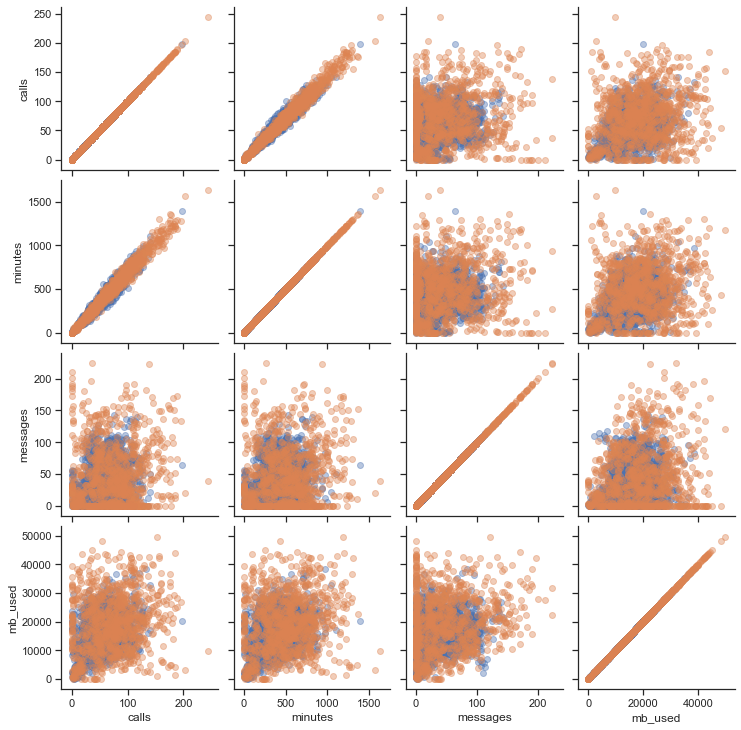

In [6]:
sns.set(style="ticks")
g = sns.PairGrid(df, hue='is_ultra')
g.map(plt.scatter, alpha=0.4)

`calls` и `minutes` дублируют друг друга. Уберем `calls`.

In [7]:
df = df.drop('calls', axis=1)
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


<a id='2'></a>
## 2. Обучение разных моделей

Розобьем данные на train, valid и test

In [8]:
# split data on training, validation and test datasets
df_train_valid, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=1)

# split train dataset to features and target
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

# split valid dataset to features and target
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

# split test dataset to features and target
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

Контроль выборок

In [9]:
print(df_test.shape)
print(df_valid.shape)
print(df_train.shape)

(643, 4)
(643, 4)
(1928, 4)


### Дерево

In [10]:
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=1, max_depth=depth)  # max_depth=4 is ok
    model_tree.fit(features_train, target_train)
    print(depth)
    print(round(model_tree.score(features_train, target_train), 3), end='   ')
    print(round(model_tree.score(features_valid, target_valid), 3))

1
0.768   0.742
2
0.794   0.771
3
0.805   0.795
4
0.814   0.796
5
0.824   0.796
6
0.836   0.795
7
0.848   0.782
8
0.865   0.785
9
0.876   0.781
10
0.886   0.785


### Случайный лес

In [11]:
for estim in range(1, 52, 5):
    model_forest = RandomForestClassifier(random_state=1, n_estimators=estim)  #estim 10-20 is ok
    model_forest.fit(features_train, target_train)
    print(estim)
    print(round(model_forest.score(features_train, target_train), 3), end='    ')
    print(round(model_forest.score(features_valid, target_valid), 3))

1
0.904    0.728
6
0.963    0.771
11
0.984    0.788
16
0.984    0.781
21
0.996    0.785
26
0.994    0.795
31
0.997    0.795
36
0.997    0.793
41
0.999    0.799
46
0.998    0.796
51
0.999    0.795


Проверим estim 21-31

In [12]:
for estim in range(21, 32):
    model_forest = RandomForestClassifier(random_state=1, n_estimators=estim)  #estim 30 is ok
    model_forest.fit(features_train, target_train)
    print(estim)
    print(round(model_forest.score(features_train, target_train), 3), end='    ')
    print(round(model_forest.score(features_valid, target_valid), 3))

21
0.996    0.785
22
0.992    0.788
23
0.993    0.779
24
0.992    0.787
25
0.995    0.787
26
0.994    0.795
27
0.996    0.793
28
0.996    0.793
29
0.997    0.796
30
0.996    0.799
31
0.997    0.795


### Логистическая регрессия

In [13]:
model_logistic = LogisticRegression(random_state=1)
model_logistic.fit(features_train, target_train)
print(model_logistic.score(features_train, target_train), end='    ')
print(model_logistic.score(features_valid, target_valid))

0.7505186721991701    0.7558320373250389


### Выводы
Наибольшее качество выдает модель слуйчайного леса с estim 17, скорость адекватная, поэтому используем эту модель.

<a id='4'></a>
## 3. Проверка модели на тестовой выборке

In [14]:
features = df_train_valid.drop('is_ultra', axis=1)
target = df_train_valid['is_ultra']

model = RandomForestClassifier(random_state=1, n_estimators=30)
model.fit(features, target)
predictions = model.predict(features_test)

accuracy = accuracy_score(target_test, predictions)
accuracy

0.7993779160186625

<a id='5'></a>
## 4. Проверка модели на адекватность

Сравним модель со случайной, таким образом оценивая ее на адекватность.

1. Допустим, что модель предсказывает объект случайным образом. С вероятностью 50/50 ответ будет «0» или «1».  Если бы мы выбирали ответ случайно, то статистически точность была 0.5, что меньше точности полученной нашей моделью.

In [15]:
random = np.random.randint(0, 2, size=len(features_test))
accuracy_random = accuracy_score(target_test, random)
accuracy_random

0.5038880248833593

2. Так как в нашем датасете 70% тариф смарт и 30% тариф ультра, допустим, что модель предсказывает объект случайным образом с веротяностью 70% «0» и 30% «1». Тогда точность будет 0.7 * 0.7 + 0.3 * 0.3 = 58%, что также меньше точности полученной нашей моделью.

In [16]:
random = []
for i in range(len(features_test)):
    random.append(np.random.choice(np.arange(0, 2), p=[0.7, 0.3]))
random = np.array(random)
accuracy_random = accuracy_score(target_test, random)
accuracy_random

0.5583203732503889

In [17]:
df['is_ultra'].value_counts() / df.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64